# Aircraft Dataset Exploration and Analysis

This notebook explores and combines two aircraft datasets for threat detection:
1. **Military Aircraft Detection Dataset** - 39,482 annotations of 96 military aircraft types with bounding boxes
2. **FGVC-Aircraft 2013b** - 10,000 images of 100 different aircraft variants (commercial and military)

**Combined Dataset**: 49,482 samples with 195 unique aircraft classes

The datasets are downloaded via Kaggle Hub with automatic caching for fast processing.


## Setup: Install Required Packages

First, install kagglehub for automatic dataset downloading and caching.


In [21]:
# Install required packages
# Note: This notebook also requires tensorflow, opencv-python, and pillow
# These are typically pre-installed in Colab, but if running locally, install them:
# %pip install tensorflow opencv-python pillow -q

%pip install kagglehub -q

print("Packages installed successfully!")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Packages installed successfully!


In [22]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import kagglehub
from pathlib import Path
from collections import Counter
from PIL import Image
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Download Datasets via Kaggle Hub

Using Kaggle Hub for automatic caching and faster data access.


In [23]:
# Download FGVC-Aircraft dataset (Commercial aircraft)
fgvc_aircraft_path = kagglehub.dataset_download("seryouxblaster764/fgvc-aircraft")
print("Path to FGVC-Aircraft dataset:", fgvc_aircraft_path)

# Download Military Aircraft Detection dataset
militaryaircraftdetectiondataset_path = kagglehub.dataset_download(
    "a2015003713/militaryaircraftdetectiondataset")
print("Path to Military Aircraft dataset:", militaryaircraftdetectiondataset_path)


Path to FGVC-Aircraft dataset: /Users/marwahfaraj/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2
Path to Military Aircraft dataset: /Users/marwahfaraj/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/95


In [24]:
## 2. Load and Process FGVC-Aircraft Dataset (Commercial Aircraft)


In [25]:
# FGVC (Commercial Aircraft) Paths
fgvc_dir = os.path.join(fgvc_aircraft_path, "fgvc-aircraft-2013b/fgvc-aircraft-2013b")
fgvc_data_dir = os.path.join(fgvc_dir, "data")
fgvc_img_dir = os.path.join(fgvc_data_dir, "images")

# Annotation Files (variant labels)
variant_filenames = {
    "train": "images_variant_train.txt",
    "validation": "images_variant_val.txt",
    "test": "images_variant_test.txt"
}

# Parse variant labels
commercial_records = []
for split, filename in variant_filenames.items():
    filepath = os.path.join(fgvc_data_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            # Split only on the first space to handle labels with spaces
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                image_id, label = parts
                image_path = os.path.join(fgvc_img_dir, f"{image_id}.jpg")
                commercial_records.append({
                    "image_id": image_id,
                    "image_path": image_path,
                    "label": label,
                    "category": "Commercial",
                    "split": split
                })

commercial_df = pd.DataFrame(commercial_records)

# Add width, height, xmin, ymin, xmax, and ymax from images_box.txt
commercial_box_path = os.path.join(fgvc_data_dir, "images_box.txt")
commercial_box_df = pd.read_csv(
    commercial_box_path,
    sep=' ',
    header=None,
    names=["image_id", "xmin", "ymin", "xmax", "ymax"],
    dtype={"image_id": str, "xmin": int, "ymin": int, "xmax": int, "ymax": int}
)

# Get image dimensions
image_dimensions_list = []
for _, row in commercial_df.iterrows():
    image_path = row["image_path"]
    with Image.open(image_path) as img:
        width, height = img.size
        image_dimensions_list.append({
            "image_id": row["image_id"],
            "width": width,
            "height": height
        })

commercial_dimensions_df = pd.DataFrame(image_dimensions_list)

# Merge dimensions into box dataframe
commercial_box_df = commercial_box_df.merge(commercial_dimensions_df, on="image_id", how="left")

# Merge into main commercial dataframe
commercial_df = commercial_df.merge(commercial_box_df, on="image_id", how="left")

# Drop image_id as it's no longer needed
commercial_df = commercial_df.drop(columns=["image_id"])

print(f"Commercial aircraft samples loaded: {len(commercial_df)}")
print(f"Unique commercial aircraft variants: {commercial_df['label'].nunique()}")
print(f"\nFirst few rows:")
commercial_df.head()


Commercial aircraft samples loaded: 10000
Unique commercial aircraft variants: 100

First few rows:


image_path    label    category  \
0  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
1  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
2  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
3  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
4  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   

   split  xmin  ymin  xmax  ymax  width  height  
0  train     3   144   998   431   1024     695  
1  train    83   155   964   462   1024     699  
2  train     1   129   891   436    913     687  
3  train     8   164   996   435   1000     678  
4  train    29   396  1268   634   1280     911

Saved: commercial_aircraft_samples.png


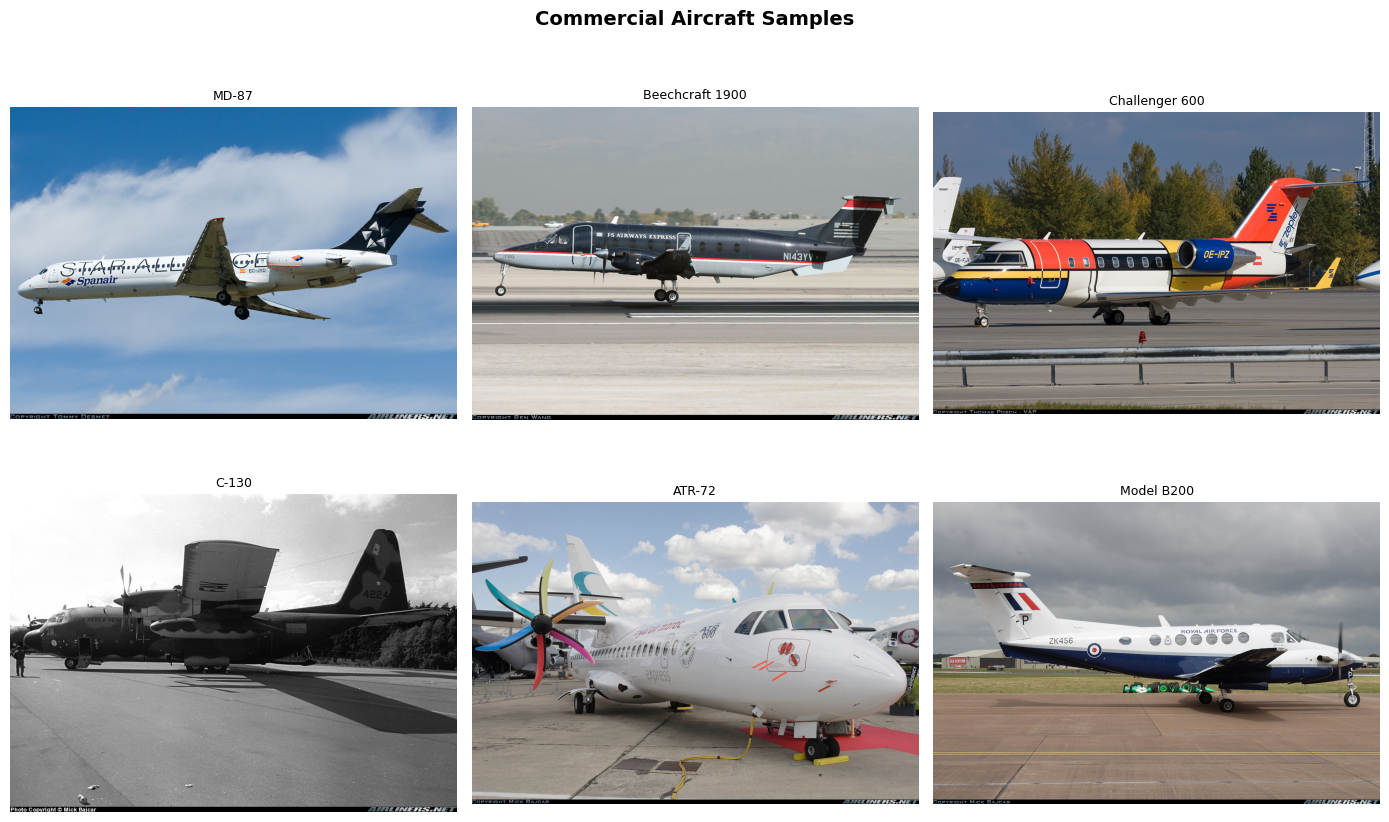

In [26]:
# Visualize sample commercial aircraft images
sample_rows = commercial_df.sample(6, random_state=42)

fig = plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.suptitle('Commercial Aircraft Samples', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure
output_dir = Path('../results/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / 'commercial_aircraft_samples.png', dpi=300, bbox_inches='tight')
print(f"Saved: commercial_aircraft_samples.png")

plt.show()


In [27]:
## 3. Load and Process Military Aircraft Detection Dataset


In [28]:
# Military Aircraft Dataset Paths
military_dataset_dir = os.path.join(militaryaircraftdetectiondataset_path, "dataset")
military_labels_path = os.path.join(militaryaircraftdetectiondataset_path, "labels_with_split.csv")

# Load labels
military_df = pd.read_csv(military_labels_path)

# Rename columns to match FGVC format
military_df = military_df.rename(columns={
    "filename": "image_path",
    "class": "label"
})

# Build full paths
military_df["image_path"] = military_df["image_path"].apply(
    lambda x: os.path.join(military_dataset_dir, x + '.jpg'))
military_df["category"] = "Military"

print(f"Military aircraft samples loaded: {len(military_df)}")
print(f"Unique military aircraft types: {military_df['label'].nunique()}")
print(f"Example Labels: {sorted(military_df['label'].unique())[:5]}")
print(f"\nFirst few rows:")
military_df.head()


Military aircraft samples loaded: 39482
Unique military aircraft types: 96
Example Labels: ['A10', 'A400M', 'AG600', 'AH64', 'AKINCI']

First few rows:


image_path  width  height label  \
0  /Users/marwahfaraj/.cache/kagglehub/datasets/a...   4928    3264  Mi28   
1  /Users/marwahfaraj/.cache/kagglehub/datasets/a...   4928    3264  Mi28   
2  /Users/marwahfaraj/.cache/kagglehub/datasets/a...   4928    3264  Mi28   
3  /Users/marwahfaraj/.cache/kagglehub/datasets/a...   4928    3264  Mi28   
4  /Users/marwahfaraj/.cache/kagglehub/datasets/a...   1360    2048  UH60   

   xmin  ymin  xmax  ymax  split  category  
0  1380  1904  1522  2014  train  Military  
1  1809  1625  1958  1759  train  Military  
2  2400  1571  2532  1727  train  Military  
3  3935  1772  4100  1891  train  Military  
4   835   526  1233   741  train  Military

Saved: military_aircraft_samples.png


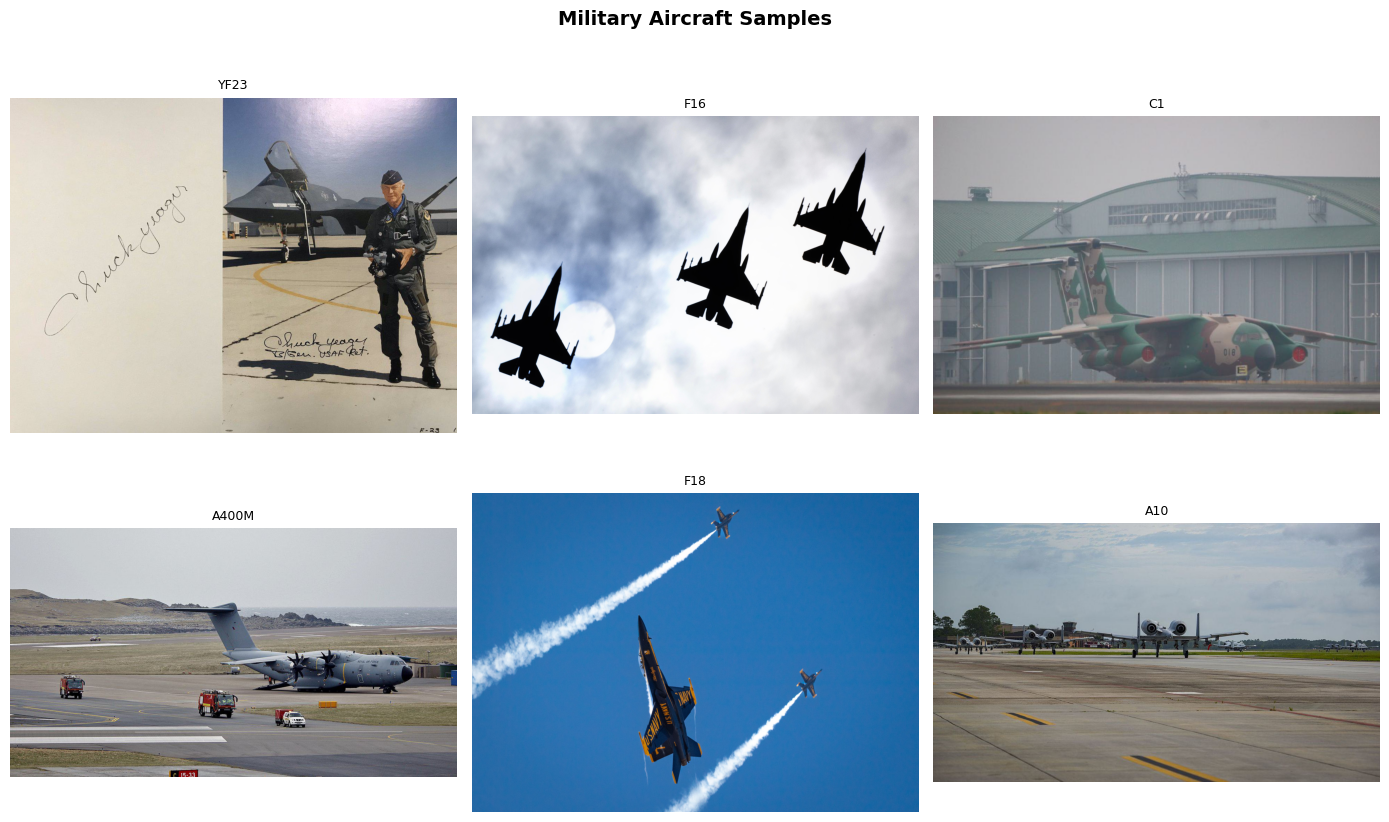

In [29]:
# Visualize sample military aircraft images
sample_rows = military_df.sample(6, random_state=42)

fig = plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.suptitle('Military Aircraft Samples', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure
output_dir = Path('../results/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / 'military_aircraft_samples.png', dpi=300, bbox_inches='tight')
print(f"Saved: military_aircraft_samples.png")

plt.show()


## 4. Merge Datasets into Combined Dataset

Combine both commercial and military aircraft datasets into a unified structure.


In [30]:
# Ensure required columns exist in both dataframes
required_cols = {"image_path", "label", "category", "width", "height", "xmin", "ymin", "xmax", "ymax"}

if not required_cols.issubset(commercial_df.columns):
    raise ValueError(f"commercial_df missing required columns: {required_cols.difference(commercial_df.columns)}")

if not required_cols.issubset(military_df.columns):
    raise ValueError(f"military_df missing required columns: {required_cols.difference(military_df.columns)}")

# Combine into unified dataset
combined_df = pd.concat([commercial_df, military_df], ignore_index=True)

print(f"Total combined samples: {len(combined_df)}")
print(f"Commercial samples: {(combined_df['category'] == 'Commercial').sum()}")
print(f"Military samples: {(combined_df['category'] == 'Military').sum()}")
print(f"\nUnique Commercial aircraft classes: {commercial_df['label'].nunique()}")
print(f"Unique Military aircraft classes: {military_df['label'].nunique()}")
print(f"Combined unique aircraft types: {combined_df['label'].nunique()}")
print(f"\nFirst few rows:")
combined_df.head()


Total combined samples: 49482
Commercial samples: 10000
Military samples: 39482

Unique Commercial aircraft classes: 100
Unique Military aircraft classes: 96
Combined unique aircraft types: 195

First few rows:


image_path    label    category  \
0  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
1  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
2  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
3  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   
4  /Users/marwahfaraj/.cache/kagglehub/datasets/s...  707-320  Commercial   

   split  xmin  ymin  xmax  ymax  width  height  
0  train     3   144   998   431   1024     695  
1  train    83   155   964   462   1024     699  
2  train     1   129   891   436    913     687  
3  train     8   164   996   435   1000     678  
4  train    29   396  1268   634   1280     911


Visualization saved to: ../results/visualizations


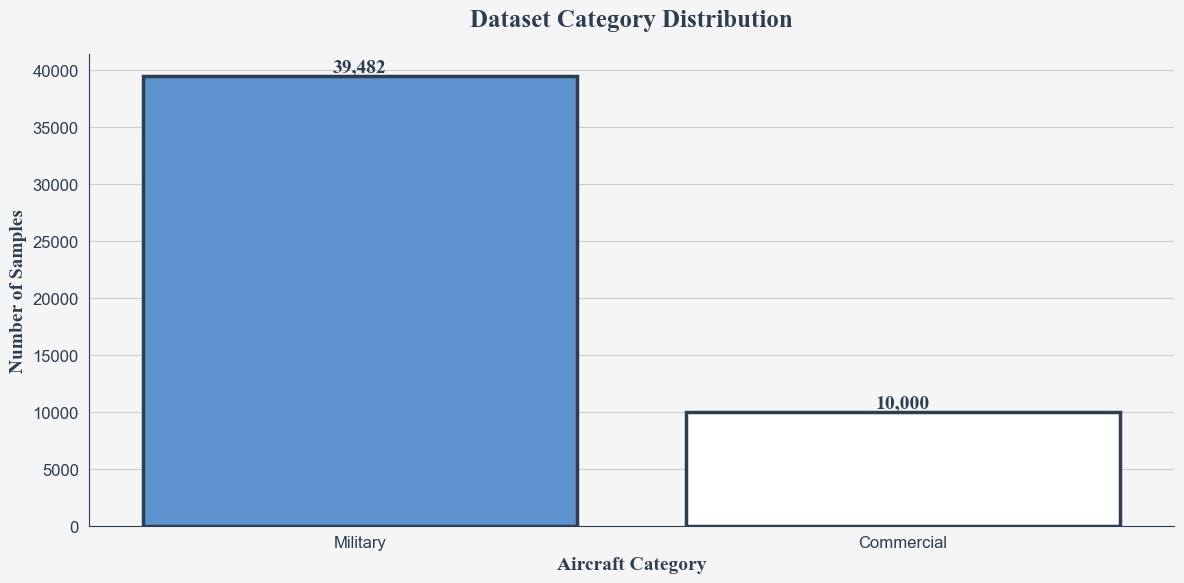


                    DATASET COMPOSITION STATISTICS                    

Commercial Aircraft:
   - Total samples: 10,000
   - Unique variants: 100

Military Aircraft:
   - Total samples: 39,482
   - Unique types: 96

                 TOP 10 COMMERCIAL AIRCRAFT VARIANTS                  
 1. 707-320                         100 samples
 2. Dornier 328                     100 samples
 3. F/A-18                          100 samples
 4. F-16A/B                         100 samples
 5. Eurofighter Typhoon             100 samples
 6. Embraer Legacy 600              100 samples
 7. ERJ 145                         100 samples
 8. ERJ 135                         100 samples
 9. EMB-120                         100 samples
10. E-195                           100 samples

                    TOP 10 MILITARY AIRCRAFT TYPES                    
 1. F16                            1941 samples
 2. F18                            1750 samples
 3. C130                           1581 samples
 4. F15         

In [31]:
# Visualize category distribution (Commercial vs Military)
# Using Seaborn with Times New Roman font for professional presentation
import seaborn as sns

# Set Times New Roman font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# Set seaborn style with light gray background
sns.set_style("whitegrid", {
    'axes.facecolor': '#F5F5F5',
    'figure.facecolor': '#F5F5F5',
    'grid.color': '#CCCCCC',
    'grid.alpha': 0.2
})

fig, ax = plt.subplots(figsize=(12, 6))

# Color scheme: Blue and White for clean, professional look
colors = ['#4A90E2', '#FFFFFF']  # Professional blue and white
category_counts = combined_df["category"].value_counts()

# Create bar plot using seaborn
bars = sns.barplot(x=category_counts.index, y=category_counts.values, 
                   palette=colors, edgecolor='#2C3E50', linewidth=2.5, ax=ax)

# Add value labels on top of bars
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    text_color = '#2C3E50'
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=14, fontweight='bold', 
            color=text_color, family='Times New Roman')

# Styling to match aerospace theme
ax.set_title("Dataset Category Distribution", 
             fontsize=18, fontweight='bold', pad=20, color='#2C3E50',
             family='Times New Roman')
ax.set_xlabel("Aircraft Category", fontsize=14, fontweight='bold', 
              color='#2C3E50', family='Times New Roman')
ax.set_ylabel("Number of Samples", fontsize=14, fontweight='bold', 
              color='#2C3E50', family='Times New Roman')
ax.tick_params(axis='both', labelsize=12, colors='#2C3E50')

# Remove top and right spines for cleaner look
sns.despine(ax=ax, top=True, right=True)
ax.spines['left'].set_color('#2C3E50')
ax.spines['bottom'].set_color('#2C3E50')

plt.tight_layout()

# Save the figure for presentation
output_dir = Path('../results/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / 'category_distribution.png', dpi=300, bbox_inches='tight', facecolor='#F5F5F5')
fig.savefig(output_dir / 'category_distribution.pdf', bbox_inches='tight', facecolor='#F5F5F5')
print(f"\nVisualization saved to: {output_dir}")

plt.show()

# Reset style after plot
sns.reset_orig()

# Show class distribution statistics
print("\n" + "="*70)
print("DATASET COMPOSITION STATISTICS".center(70))
print("="*70)
print(f"\nCommercial Aircraft:")
print(f"   - Total samples: {len(commercial_df):,}")
print(f"   - Unique variants: {commercial_df['label'].nunique()}")
print(f"\nMilitary Aircraft:")
print(f"   - Total samples: {len(military_df):,}")
print(f"   - Unique types: {military_df['label'].nunique()}")

print(f"\n{'='*70}")
print("TOP 10 COMMERCIAL AIRCRAFT VARIANTS".center(70))
print("="*70)
for idx, (aircraft, count) in enumerate(commercial_df['label'].value_counts().head(10).items(), 1):
    print(f"{idx:2d}. {aircraft:<30} {count:>4} samples")

print(f"\n{'='*70}")
print("TOP 10 MILITARY AIRCRAFT TYPES".center(70))
print("="*70)
for idx, (aircraft, count) in enumerate(military_df['label'].value_counts().head(10).items(), 1):
    print(f"{idx:2d}. {aircraft:<30} {count:>4} samples")


In [32]:
# Save statistics and dataset summaries for presentation
output_dir = Path('../results/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

# Save dataset summary statistics
summary_stats = {
    'Total Samples': len(combined_df),
    'Commercial Samples': len(commercial_df),
    'Military Samples': len(military_df),
    'Total Unique Classes': combined_df['label'].nunique(),
    'Commercial Variants': commercial_df['label'].nunique(),
    'Military Types': military_df['label'].nunique()
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(output_dir / 'dataset_summary_stats.csv', index=False)

# Save top 10 aircraft types for each category
top_commercial = commercial_df['label'].value_counts().head(10).reset_index()
top_commercial.columns = ['Aircraft_Variant', 'Count']
top_commercial.to_csv(output_dir / 'top_10_commercial_aircraft.csv', index=False)

top_military = military_df['label'].value_counts().head(10).reset_index()
top_military.columns = ['Aircraft_Type', 'Count']
top_military.to_csv(output_dir / 'top_10_military_aircraft.csv', index=False)

# Save category distribution
category_dist = combined_df['category'].value_counts().reset_index()
category_dist.columns = ['Category', 'Count']
category_dist.to_csv(output_dir / 'category_distribution.csv', index=False)

# Save the complete combined dataset
combined_df.to_csv(output_dir / 'combined_dataset_full.csv', index=False)

print("\n" + "="*70)
print("SAVED FILES FOR PRESENTATION".center(70))
print("="*70)
print(f"\nVisualizations (all at 300 DPI):")
print(f"   - category_distribution.png & .pdf")
print(f"   - commercial_aircraft_samples.png")
print(f"   - military_aircraft_samples.png")
print(f"   - combined_dataset_samples.png")
print(f"\nStatistics CSV files:")
print(f"   - dataset_summary_stats.csv")
print(f"   - top_10_commercial_aircraft.csv")
print(f"   - top_10_military_aircraft.csv")
print(f"   - category_distribution.csv")
print(f"\nComplete Dataset:")
print(f"   - combined_dataset_full.csv ({len(combined_df):,} samples)")
print(f"\nLocation: {output_dir.absolute()}")
print("="*70)



                     SAVED FILES FOR PRESENTATION                     

Visualizations (all at 300 DPI):
   - category_distribution.png & .pdf
   - commercial_aircraft_samples.png
   - military_aircraft_samples.png
   - combined_dataset_samples.png

Statistics CSV files:
   - dataset_summary_stats.csv
   - top_10_commercial_aircraft.csv
   - top_10_military_aircraft.csv
   - category_distribution.csv

Complete Dataset:
   - combined_dataset_full.csv (49,482 samples)

Location: /Users/marwahfaraj/Desktop/ms_degree_application_and_doc/final_projects/521_final_project/Aircraft-Threat-Detection-Using-Computer-Vision/notebooks/../results/visualizations


Saved: combined_dataset_samples.png


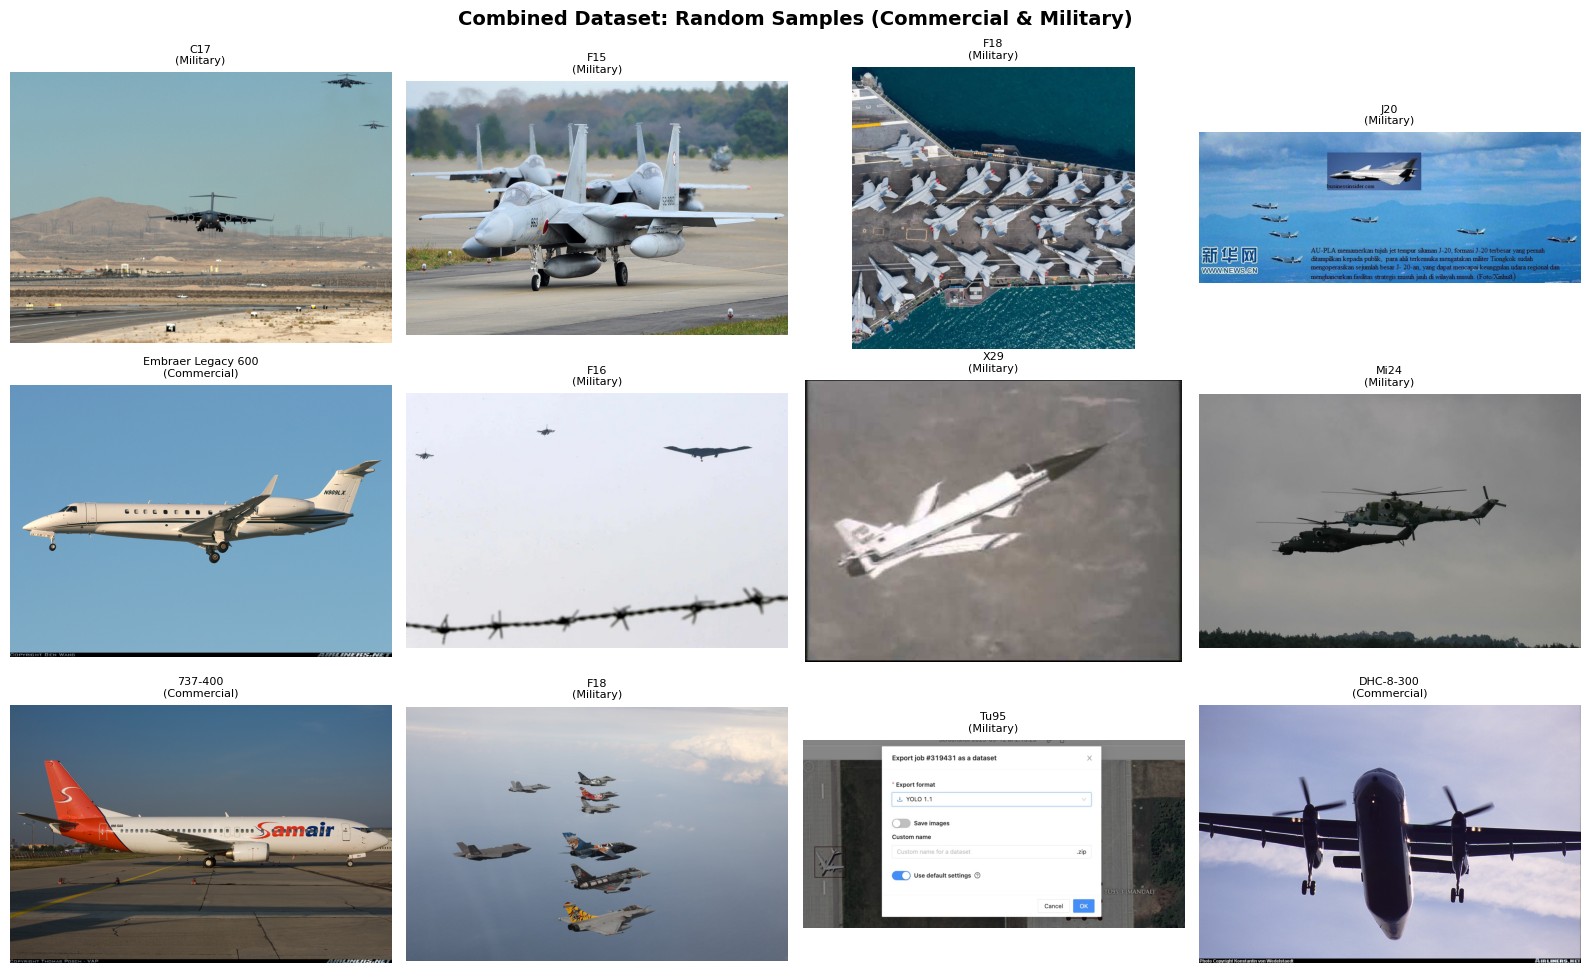

In [33]:
# Visualize 12 random samples from combined dataset
sample_rows = combined_df.sample(12, random_state=42)
fig = plt.figure(figsize=(16, 10))

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(f"{row['label']}\n({row['category']})", fontsize=8)
    plt.axis("off")

plt.suptitle('Combined Dataset: Random Samples (Commercial & Military)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure
output_dir = Path('../results/visualizations')
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / 'combined_dataset_samples.png', dpi=300, bbox_inches='tight')
print(f"Saved: combined_dataset_samples.png")

plt.show()


## 5. Dataset Summary and Comparison


In [34]:
# Dataset comparison summary
comparison = pd.DataFrame({
    'Dataset': ['Military Aircraft', 'FGVC-Aircraft (Commercial)', 'Combined'],
    'Total Samples': [
        len(military_df),
        len(commercial_df),
        len(combined_df)
    ],
    'Unique Classes': [
        military_df['label'].nunique(),
        commercial_df['label'].nunique(),
        combined_df['label'].nunique()
    ],
    'Has Bounding Boxes': ['Yes', 'Yes', 'Yes'],
    'Category': ['Military Only', 'Commercial Only', 'Both'],
    'Primary Use': ['Object Detection', 'Classification', 'Threat Detection']
})

print("Dataset Comparison:")
print("=" * 90)
print(comparison.to_string(index=False))
print("=" * 90)

# Show column information for combined dataset
print("\n\nCombined Dataset Columns:")
print("=" * 50)
for col in combined_df.columns:
    print(f"  - {col}: {combined_df[col].dtype}")
print("\nSample count per split:")
if 'split' in combined_df.columns:
    print(combined_df['split'].value_counts())


Dataset Comparison:
                   Dataset  Total Samples  Unique Classes Has Bounding Boxes        Category      Primary Use
         Military Aircraft          39482              96                Yes   Military Only Object Detection
FGVC-Aircraft (Commercial)          10000             100                Yes Commercial Only   Classification
                  Combined          49482             195                Yes            Both Threat Detection


Combined Dataset Columns:
  - image_path: object
  - label: object
  - category: object
  - split: object
  - xmin: int64
  - ymin: int64
  - xmax: int64
  - ymax: int64
  - width: int64
  - height: int64

Sample count per split:
split
train         32979
validation    10522
test           5981
Name: count, dtype: int64


## 6. Generate TensorFlow Datasets for Training

Create TensorFlow datasets with train/validation/test splits for model training.


In [36]:
# Function to load images and labels for TensorFlow
def load_image_and_labels(features):
    """Load and preprocess image with labels for TensorFlow training."""
    image = tf.io.read_file(features['image_path'])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    
    # Extract bounding box coordinates and labels
    xmin = tf.cast(features['xmin'], tf.float32)
    ymin = tf.cast(features['ymin'], tf.float32)
    xmax = tf.cast(features['xmax'], tf.float32)
    ymax = tf.cast(features['ymax'], tf.float32)
    label = features['label']
    category = features['category']
    
    # Normalize bounding box coordinates to [0, 1]
    width = tf.cast(features['width'], tf.float32)
    height = tf.cast(features['height'], tf.float32)
    bbox = tf.stack([ymin / height, xmin / width, ymax / height, xmax / width])
    
    return image, {'bbox': bbox, 'label': label, 'category': category}

# Create a copy and assign train/val/test splits
combined_shuffled_df = combined_df.copy()

# Assign split based on existing split column if available, otherwise create new splits
if 'split' not in combined_shuffled_df.columns:
    combined_shuffled_df['split'] = np.random.choice(
        ["train", "validation", "test"],
        p=[0.8, 0.1, 0.1],
        size=len(combined_shuffled_df)
    )

# Create TensorFlow datasets for each split
train_ds = tf.data.Dataset.from_tensor_slices(
    dict(combined_shuffled_df[combined_shuffled_df['split'] == 'train'])
).map(load_image_and_labels)

val_ds = tf.data.Dataset.from_tensor_slices(
    dict(combined_shuffled_df[combined_shuffled_df['split'] == 'validation'])
).map(load_image_and_labels)

test_ds = tf.data.Dataset.from_tensor_slices(
    dict(combined_shuffled_df[combined_shuffled_df['split'] == 'test'])
).map(load_image_and_labels)

print(" TensorFlow Datasets Created:")
print(f"  - Training samples: {len(combined_shuffled_df[combined_shuffled_df['split'] == 'train'])}")
print(f"  - Validation samples: {len(combined_shuffled_df[combined_shuffled_df['split'] == 'validation'])}")
print(f"  - Test samples: {len(combined_shuffled_df[combined_shuffled_df['split'] == 'test'])}")

# Show example
print("\n Example from Training Dataset:")
for image, labels in train_ds.take(1):
    print(f"  - Image shape: {image.shape}")
    print(f"  - Bounding Box (normalized): {labels['bbox'].numpy()}")
    print(f"  - Label: {labels['label'].numpy()}")
    print(f"  - Category: {labels['category'].numpy()}")


 TensorFlow Datasets Created:
  - Training samples: 32979
  - Validation samples: 10522
  - Test samples: 5981

 Example from Training Dataset:
  - Image shape: (695, 1024, 3)
  - Bounding Box (normalized): [0.20719424 0.00292969 0.6201439  0.9746094 ]
  - Label: b'707-320'
  - Category: b'Commercial'


## 7. Key Insights and Summary

### Combined Dataset Overview:
- **49,482 total samples** with bounding box annotations
- **195 unique aircraft classes** (96 military + 100 commercial variants)
- **Category labels** enable threat classification (Commercial vs Military)
- **Ready for training** with TensorFlow datasets pre-configured

### Military Aircraft Component (39,482 samples):
- Focused on **military aircraft** (helicopters, fighters, bombers, transports, etc.)
- Examples: F16, F18, A10, Apache (AH64), Blackhawk (UH60), C130
- Multiple objects can appear in a single image
- Essential for **threat detection** and military aircraft identification

### Commercial Aircraft Component (10,000 samples):
- **100 commercial aircraft variants** from FGVC dataset
- Fine-grained labels (e.g., 707-320, 737-700, F/A-18, etc.)
- Mix includes both civilian and some military variants
- Balanced distribution (~100 images per class)
- Important for **distinguishing civilian traffic** from threats

### Key Features of Combined Dataset:
1. **Unified structure** with standardized columns (`image_path`, `label`, `category`, `width`, `height`, `xmin`, `ymin`, `xmax`, `ymax`)
2. **Bounding boxes** for all aircraft enable object detection training
3. **Category field** enables automatic threat assessment
4. **Image dimensions** included for preprocessing and normalization
5. **Kaggle Hub caching** makes dataset loading fast (seconds, not minutes)

### Use Cases:
**Object Detection**: Train YOLO models to detect and localize aircraft in images  
**Classification**: Identify specific aircraft variants for detailed analysis  
**Threat Assessment**: Automatically classify detected aircraft as commercial or military  
**Multi-task Learning**: Combine detection, classification, and threat assessment in one system
